<center>Заметка 8.а Парная калибровка</center>
<center>курса <q>Введение в цифровую обработку изображений</q>.</center>
<center>Шокуров Антон В.</center>
<center>shokurov.anton.v@yandex.ru</center>
<center>http://машинноезрение.рф</center>
<center>Версия 0.09</center>

<center>Аннотация</center>
<p>
...
</p>

<p>Это предварительная версия! Любые замечания приветствуются.</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plot3d
import cv2 as cv
from matplotlib import cm
from matplotlib.ticker import MaxNLocator
import scipy.stats as stats
import scipy.spatial.transform as transform
from sklearn.decomposition import PCA

/opt/conda/envs/myTF/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Для точной повторяемости некоторых из результатов.
# для совместимости: np.random.seed(2021)
rng = np.random.default_rng(2021)
rng.standard_normal()
# Должно быть -0.06886119500819549

In [4]:
path2img = './camera_calib/cap/cullman_box_35_57/'

<h3>Парная калибровка</h3>

Данный подход более общий чем восстановление по стереокамерам.
Далее рассматривается две камеры, но можно было использовть и большее количество.
Важно отметить, что камеры будут откалиброваны относительно образца, а не между собой (как в случае стерео камер).

Напомним основную фишку калибровки по стереокамерам - если выполнить ретификацию изображений, то для поиска "хорошой" точки на втором изображении, зная ее положенрия на первом, достаточн использовать метод поиска по шаблону пробегая одну полосу (с фиксированым y), а не пробегать все изображение целиком.
Забегая вперед, скажем, что в методе парной калибровки, также не приходится пробегать все изображение, для этого использвуются дескрипторы, при этом очевидый плюс данного метода - это отсутствие необходимости в стереокамере.

Загрузим фото однаго и того же объекта с разных ракурсов.

In [5]:
str1 = 'ref1_clean.png'
str2 = 'ref2_clean.png'

ref1 = cv.imread( path2img + str1 )
ref2 = cv.imread( path2img + str2 )

ref = [ref1, ref2]

Покажем изображения который будут использованы для (внешней) калибровки каждой из камер.

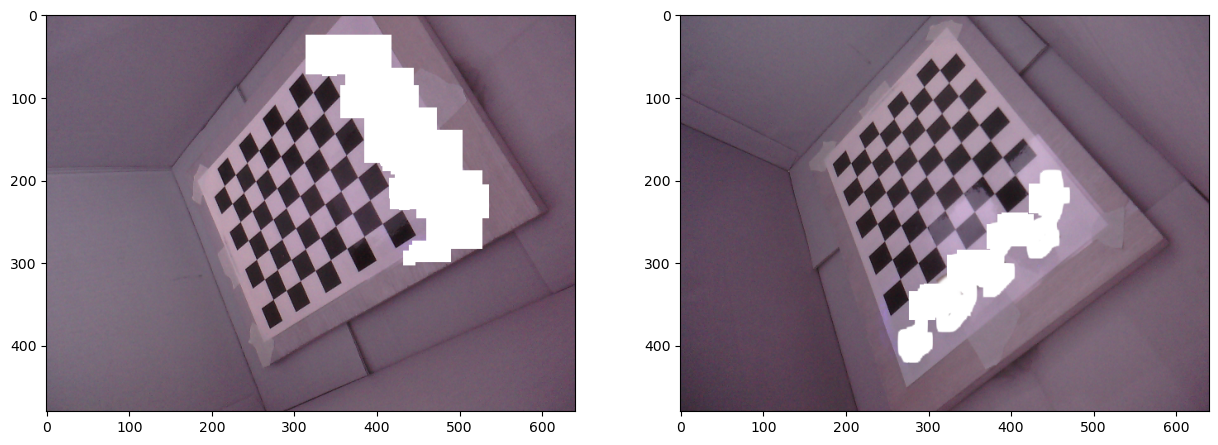

In [7]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches( (15, 15) )
ax[0].imshow( ref1 )
ax[1].imshow( ref2 );

Будем искать шахматную доску размера (7, 8).
Создадим сетку (obj_pnts) представляющую расположение узлов доски в мировой системе координат.

In [9]:
pat_size = (7,8)
obj_pnts = np.zeros( (np.prod( pat_size ), 3), np.float32)
obj_pnts[:,:2] = np.indices( pat_size ).T.reshape(-1,2)

print( obj_pnts.shape )

(56, 3)


Найдем шахматную доску на изображениях. Для этого воспользуемся встроеной функцией opencv findChessboardCorners, для того чтобы найти вершины пересечения полей, а затем применим функцию суб-пиксельного уточнения углов cornerSubPixю. 

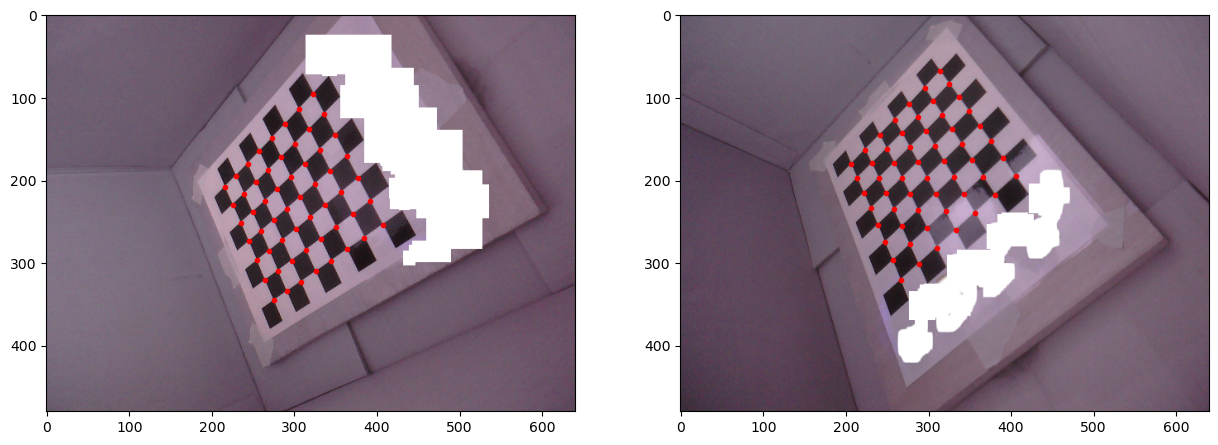

In [12]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches( (15, 15) )

criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

imgs_pnts = []
for ii, img in enumerate(ref):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    fnd, crnrs = cv.findChessboardCorners(gray, pat_size)
    corners2 = cv.cornerSubPix( gray, crnrs, pat_size, (-1,-1), criteria)
    crnrs = corners2
    if not fnd:
        continue

    img_pnts = crnrs.reshape(-1, 2)
    imgs_pnts.append( img_pnts )
    ax[ii].imshow( img )
    ax[ii].plot( img_pnts[:,0], img_pnts[:,1] , "r." )

Загрузим калибровочные параметры камеры.

In [14]:
calib_path = "./camera_calib/calib/"
dist_c = np.loadtxt( calib_path + 'dist_.csv', delimiter=',' )
cam_m = np.loadtxt( calib_path + 'camera_.csv', delimiter=',' )

Выполним внешнюю калибровку камер, т.е. найдем расположение каждой из них относительно шахматной доски.

Переменная imgs_pnts содержит координаты на изображении точек, которые должны соответствовать известным 3D координатам в мировой системе координат. Переменная obj_pnts содержит соответствующие 3D координаты.
С помощью функции cv.solvePnPRansac производится оценка вектора поворота rvec и вектора смещения tvec камеры в мировой системе координат. Эта функция использует алгоритм RANSAC для отброса выбросов.
Затем с помощью функции cv.Rodrigues создается матрица поворота rot_m из вектора поворота rvec.
Затем матрица поворота rot_m и вектор смещения tvec объединяются в одну матрицу proj_mat и умножаются на матрицу калибровки камеры cam_m. Это позволяет получить итоговую проективную матрицу proj_mat.



In [17]:
rvecs = []
tvecs = []
proj = []

for img_pnts in imgs_pnts:
    ret, rvec, tvec, inliers = cv.solvePnPRansac( obj_pnts, img_pnts, cam_m, dist_c) # Зависит только от параметров одной камеры.
    # Положение и поворот камер вычисляются независимым образом для каждой из камер.

    # print(ret, inliers)
    if not ret:
        continue

    # Создаем матрицу поворота по вектору повороту.
    rot_m, _ = cv.Rodrigues( rvec )
    # Объединяем матрицу поворота и вектор смещения в одну матрицу и умножаем на проективуню матрицу.
    proj_mat = cam_m.dot(cv.hconcat( (rot_m, tvec) ))
    # В итоге получаем итоговую проективную матрицу.

    proj.append( proj_mat )
    rvecs.append( rvec )
    tvecs.append( tvec )

In [ ]:
np.savetxt("./porj_1.txt", proj[0])
np.savetxt("./porj_2.txt", proj[1])
np.savetxt("./rvec_1.txt", rvecs[0])
np.savetxt("./rvec_2.txt", rvecs[1])
np.savetxt("./tvec_1.txt", tvecs[0])
np.savetxt("./tvec_2.txt", tvecs[1])

rvecs задает вектор поворота камеры.

In [21]:
rvecs[0]

array([[-0.73465575],
       [ 0.49407212],
       [-2.02606052]])

tvecs задает смещение камеры

In [22]:
tvecs[0]

array([[-1.91404615],
       [ 4.59358839],
       [22.29051881]])

Выполним проекцию точки в мировой системе кординат на плоскость камеры.

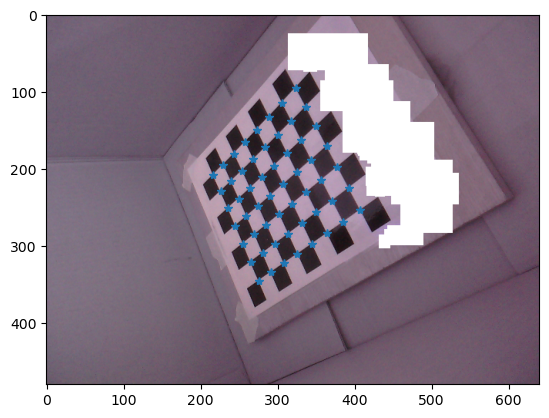

In [24]:
pp = cv.projectPoints(obj_pnts, rvecs[0], tvecs[0], cam_m, dist_c)[0].reshape(-1, 2)
# Репроэкция узлов доски.
plt.imshow( ref[0] )
plt.plot( pp[:,0], pp[:,1], '*');

<b>Триангуляция</b>

Зная проекцию точки с двух камер можно восстановить её положение в 3D. Триангуляция (реконструкция) — процесс определения точки в трехмерном пространстве с учетом ее проекций на два или более изображений. Когда у нас есть много проекций на плоское изображение и мы восстанавливаем 3D координату. Наборы одинаковых точек на разных изображений генерируют набор линий в пространстве, которые пересекаются в точке х. Но из-за шума бывает так, что сгенерированные линии не пересекаются или же пересекаются не в той точке. То есть задача состоит в том, чтобы найти трехмерную точку, которая оптимально соответствует измеренными точками изображения.
    <center> 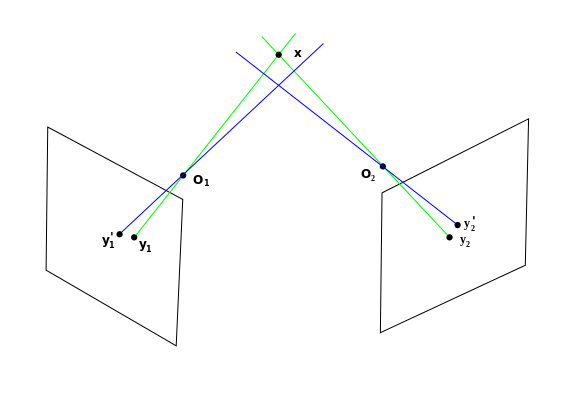 </center>

Для улучшения качества можно применить устранение дисторсии (которая возникает из-за искажений в линзах камеры).

In [25]:
def undistP( p ):
    markIm0 = np.array( p.copy(), dtype=np.float32 )
    #print( markIm0 )
    markIm0 = np.expand_dims(markIm0, axis=1)
    markIm0 = cv.undistortPoints( markIm0, cam_m, dist_c, None, cam_m) # Устраняем эффект дисторсии для точки.
    return markIm0

Покажем эффект от устранения дисторсии.

In [26]:
imgs_pnts[0][20]

array([243.24165, 179.8579 ], dtype=float32)

In [27]:
uP0 = undistP( imgs_pnts[0][20] )
uP0

array([[[243.3743 , 180.00397]]], dtype=float32)

Разница небольшая, но есть.

In [28]:
uP1 = undistP( imgs_pnts[1][20] )
uP1

array([[[336.75122, 100.00534]]], dtype=float32)

Выполним преобразование точки к нужной размерности. (к вектору столбцу)

In [30]:
markIm0 = np.transpose( uP0, axes=[1,2,0] )[0]
markIm1 = np.transpose( uP1, axes=[1,2,0] )[0]
markIm0, markIm1

(array([[243.3743 ],
        [180.00397]], dtype=float32),
 array([[336.75122],
        [100.00534]], dtype=float32))

In [31]:
markIm0.shape

(2, 1)

Восстановим точку в трехмерном пространстве.

In [32]:
# Камеры задаются проективными матрицами.
pnt4d = cv.triangulatePoints( proj[0], proj[1], markIm0, markIm1  )

Получим точку в 3д, но в проективном пространстве, т.е. из 4х компонент.

In [33]:
pnt4d

array([[-9.3710816e-01],
       [-3.1211874e-01],
       [-9.1353228e-04],
       [-1.5623498e-01]], dtype=float32)

Приведем к настоящей трехмерной.

In [34]:
pnt3d_0 = pnt4d[:,0]/pnt4d[-1,0]
pnt3d_0 # Замечу, что координаты очень близки к целым числам.

array([5.9980688e+00, 1.9977520e+00, 5.8471686e-03, 1.0000000e+00],
      dtype=float32)

По координатам восстановим индекс точки и сравним с тем что должно быть.

In [35]:
20 == 2*7+6

True

Итоговая точка в 3д.

In [36]:
pnt3d_0[:3] # Последняя координата равна 1.

array([5.9980688e+00, 1.9977520e+00, 5.8471686e-03], dtype=float32)